In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/iLQGameSolver/examples/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using Plots
using SparseArrays
using Random
using Test
using StaticArrays
using iLQGameSolver
using BenchmarkTools

┌ Info: Precompiling iLQGameSolver [894a8279-595f-4c20-8f0c-63b9232f715b]
└ @ Base loading.jl:1342
┌ Warning: Package iLQGameSolver does not have SparseArrays in its dependencies:
│ - If you have iLQGameSolver checked out for development and have
│   added SparseArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with iLQGameSolver
└ Loading SparseArrays into iLQGameSolver from project dependency, future warnings for iLQGameSolver are suppressed.


### 2D Point Mass Continous dynamics

The 2D point masses with mass $m=1\; \text{kg}$ are subject to input forces $F_{ext}$ and damping coefficient $c = 0.1\;[N \cdot \frac{s}{m}]$.


\begin{split}
\dot p &= v\\
\dot v &= -\frac{b}{m}v + \frac{1}{m}F_{ext}
\end{split}

#### Point Mass Discrete

The discrete time linear dynamics for two 2D point masses are as described below: 
$$\begin{equation}
    x_{t+1} = A_tx_t + B^1_tu^1_t + B^2_tu^2_t
\end{equation} $$
where the $A_t$ matrix is:
$$\begin{equation}
    A_t = \begin{bmatrix}   1 & 0 & h & 0 & 0 & 0 & 0 & 0               \\ 
                            0 & 1 & 0 & h & 0 & 0 & 0 & 0               \\ 
                            0 & 0 & 1-(c/m_1)*h & 0 & 0 & 0 & 0 & 0     \\ 
                            0 & 0 & 0 & 1-(c/m_1)*h & 0 & 0 & 0 & 0     \\
                            0 & 0 & 0 & 0 & 1 & 0 & h & 0               \\ 
                            0 & 0 & 0 & 0 & 0 & 1 & 0 & h               \\ 
                            0 & 0 & 0 & 0 & 0 & 0 & 1-(c/m_2)*h & 0     \\ 
                            0 & 0 & 0 & 0 & 0 & 0 & 0 & 1-(c/m_2)*h     \\ 
    \end{bmatrix}
\end{equation} $$
the $B^1_t$ and $B^2_t$ matrices are:
$$\begin{equation}
    B^1_t = \begin{bmatrix} 0 & 0       \\ 
                            0 & 0       \\ 
                            h/m_1 & 0   \\ 
                            0 & h/m_1   \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\
    \end{bmatrix},
    B^2_t = \begin{bmatrix} 0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            h/m_2 & 0   \\ 
                            0 & h/m_2   \\
    \end{bmatrix}
\end{equation} $$
the $x_t$, $u^1_t$, and $u^2_t$ vectors are:
$$\begin{equation}
    x_t = \begin{bmatrix}   x_1         \\ 
                            y_1         \\ 
                            \dot{x}_1   \\ 
                            \dot{y}_1   \\ 
                            x_2 \\ y_2  \\ 
                            \dot{x}_2   \\ 
                            \dot{y}_2   \\
    \end{bmatrix},
    u^1_t = \begin{bmatrix} u^1_x   \\
                            u^1_y   \\
    \end{bmatrix},
    u^2_t = \begin{bmatrix} u^2_x   \\ 
                            u^2_y   \\ 
    \end{bmatrix}
\end{equation} $$

The variables $c$, $h$, $m_1$, and $m_2$ are the damping coefficients [N-s/m], time steps [s], mass of the first agent [kg], and mass of the second agent [kg], respectively.

$$\begin{bmatrix} S11 & S12 \\ S21 & S22 \end{bmatrix}
\begin{bmatrix} P1 \\ P2 \end{bmatrix} = 
\begin{bmatrix} Y1 \\ Y2 \end{bmatrix}$$

$$ \begin{bmatrix} R^{11} + (B^{1'} * V₁ * B^1) & (B^{1'} * V₁ * B^2) \\ (B^{2'} * V_2 * B^1) & R^{22} + (B^{2'} * V_2 * B^2) \end{bmatrix}$$

<!-- $$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$ -->


In [3]:
# Setup the problem

dt = 0.1                    # Step size [s]
tf = 10.0                    # Horizon [s]
N = trunc(Int, tf/dt)         # Number of steps (knot points)

# Define cost matrices 
nx = 4 
nu = 2
Nplayer = 3

Nu = nu * Nplayer
Nx = nx * Nplayer

Q1 = sparse(zeros(Nx,Nx))     # State cost for agent 1
Q1[1:nx,1:nx] .= 3.0*I(nx)
Qn1 = Q1                    # Terminal cost for agent 1

Q2 = sparse(zeros(Nx,Nx))     # State cost for agent 2
Q2[nx+1:2*nx,nx+1:2*nx] .= 3.0*I(nx)
Qn2 = Q2                    # Terminal cost for agent 2

Q3 = sparse(zeros(Nx,Nx))     # State cost for agent 2
Q3[2*nx+1:3*nx,2*nx+1:3*nx] .= 3.0*I(nx)
Qn3 = Q3                    # Terminal cost for agent 2

R11 = sparse(1.0*I(2))              # Control cost for player 1
R12 = sparse(0.0*I(2))     # Control cost for player 1 associated with player 2's controls
R13 = sparse(0.0*I(2))     # Control cost for player 2 associated with player 1's controls
R21 = sparse(0.0*I(2))     # Control cost for player 2 associated with player 1's controls
R22 = sparse(1.0*I(2))              # Contorl cost for player 2
R23 = sparse(0.0*I(2))     # Control cost for player 2 associated with player 1's controls
R31 = sparse(0.0*I(2))     # Control cost for player 2 associated with player 1's controls
R32 = sparse(0.0*I(2))     # Control cost for player 2 associated with player 1's controls
R33 = sparse(1.0*I(2))     # Control cost for player 2 associated with player 1's controls

dmax = 2.5                  # Distance that both agents should keep between each other [m]
ρ = 500.0                   # Penalty factor for violating the distance constraint

# Q's are stacked vertically
Q = sparse(zeros(Float32, Nx*Nplayer, Nx))
# @show size([Q1; Q2; Q3]), size(Q)
#Q .= [Q1; Q2]
Q .= [Q1; Q2; Q3]

# Qn's are stacked vertically
Qn = sparse(zeros(Float32, Nx*Nplayer, Nx))
#Qn .= [Qn1; Qn2]
Qn .= [Qn1; Qn2; Qn3]

# R's are stacked as a matrix
R = sparse(zeros(Float32, Nu, Nu))
#R .= [R11 R12; R21 R22]
R .= [R11 R12 R13; R21 R22 R23; R31 R32 R33]

NHor = N
tol = 1e-2

game = iLQGameSolver.GameSetup(nx, nu, Nplayer, Q, R, Qn, dt, tf, NHor, dmax, ρ, tol)

solver = iLQGameSolver.iLQSetup(Nx, Nu, Nplayer, NHor)

solver.P = rand(NHor, Nu, Nx)*0.03
solver.α = rand(NHor, Nu)*0.03;

In [4]:
# Initial and final states
# x₁, y₁, ̇x₁, ̇y₁, x₂, y₂, ̇x₂, ̇y₂       

x₀= [   5.0; 0.0; 0.0; 0.0; 
        0.0; 5.0; 0.0; 0.0; 
        0.0; 0.0; 0.0; 0.0] 
        # Initial state

xgoal = [   5.0; 10.0; 0.0; 0.0; 
            10.0; 5.0; 0.0; 0.0; 
            10.0; 10.0; 0.0; 0.0]   
        # Final state

# Input constraints
umax = [2.0, 2.0, 
        2.0, 2.0, 
        2.0, 2.0]   

umin = [-2.0, -2.0, 
        -2.0, -2.0, 
        -2.0, -2.0]

ugoal = [   0.0, 0.0, 
            0.0, 0.0,  
            0.0, 0.0]     

game.x0 .= x₀
game.xf .= xgoal
game.umin .= umin
game.umax .= umax
game.uf .= ugoal;

In [5]:
X,U = iLQGameSolver.solveILQGame(game, solver, iLQGameSolver.pointMass, iLQGameSolver.costPointMass, x₀, true);

In [20]:
xNoise, uNoise = iLQGameSolver.rolloutRK4(game, solver, iLQGameSolver.pointMass, x₀, 0.5, true)
xNoise[end,:,:]

12×1 Matrix{Float64}:
  5.146171035980142
 10.149873245950065
 -0.002003459055462454
  0.006683779457807693
 10.14077016623066
  5.13452740549031
  0.00859829116735944
  0.009821054164688406
 10.112100973922672
 10.155242332584347
  0.0114970750104526
  0.011791627774655358

In [21]:
xend = xNoise[end,:,:]

@test xend[1] ≈ xgoal[1] atol=1e0 
@test xend[2] ≈ xgoal[2] atol=1e0 
@test xend[3] ≈ xgoal[3] atol=1e-1 
@test xend[4] ≈ xgoal[4] atol=1e-1 
@test xend[5] ≈ xgoal[5] atol=1e0 
@test xend[6] ≈ xgoal[6] atol=1e0 
@test xend[7] ≈ xgoal[7] atol=1e-1 
@test xend[8] ≈ xgoal[8] atol=1e-1 
@test xend[9] ≈ xgoal[9] atol=1e0 
@test xend[10] ≈ xgoal[10] atol=1e0 
@test xend[11] ≈ xgoal[11] atol=1e-1 
@test xend[12] ≈ xgoal[12] atol=1e-1 

Test Passed

┌ Info: Saved animation to /home/ahmed/.julia/dev/iLQGameSolver/examples/assets/gifs/iLQGameNoise.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/.julia/dev/iLQGameSolver/examples/assets/gifs/iLQGameNoise.gif")
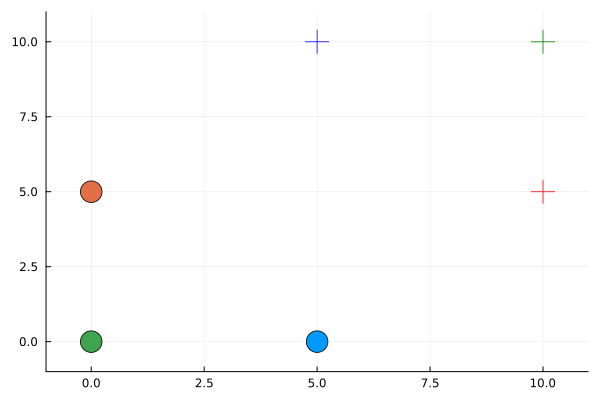

In [7]:
# Animation of the solution. GIF is saved in the assets folder.

anim = @animate for t in 1:N-1
    scatter([xNoise[t,1,:]], [xNoise[t,2,:]], m = (:circle, 12),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
    scatter!([xNoise[t,5,:]], [xNoise[t,6,:]], m = (:circle, 12))
    scatter!([xNoise[t,9,:]], [xNoise[t,10,:]], m = (:circle, 12))
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :blue))
    plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
    plot!([xgoal[9]], [xgoal[10]], m = (:cross, 12, :green))
end every 1;
gif(anim, "assets/gifs/iLQGameNoise.gif")

In [8]:
X[end,:,:]

12×1 Matrix{Float64}:
  4.9999737691722315
  9.99870406295046
  3.826384227941833e-5
  0.0026141255685572396
  9.999824499515206
  5.0002693986083955
  0.0007365047748870179
 -0.000517995851991387
  9.998626657287904
  9.999788644586829
  0.002770369314759929
  0.0007955729297341336

┌ Info: Saved animation to /home/ahmed/.julia/dev/iLQGameSolver/examples/assets/gifs/iLQGameExample.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/.julia/dev/iLQGameSolver/examples/assets/gifs/iLQGameExample.gif")
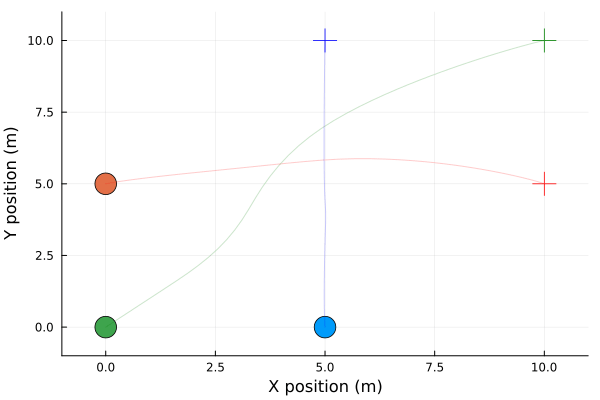

In [10]:
# Animation of the solution. GIF is saved in the assets folder.

anim = @animate for t in 1:N-1
    scatter([X[t,1,:]], [X[t,2,:]], m = (:circle, 12),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
    scatter!([X[t,5,:]], [X[t,6,:]], m = (:circle, 12))
    scatter!([X[t,9,:]], [X[t,10,:]], m = (:circle, 12))
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :blue))
    plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
    plot!([xgoal[9]], [xgoal[10]], m = (:cross, 12, :green))
    plot!([X[:,1,:]], [X[:,2,:]], xlims = (-1, 11), ylims = (-1, 11), legend = false, 
    color = "blue", 
    linealpha = 0.2, 
    xlabel = "X position (m)",
    ylabel = "Y position (m)")
    plot!([X[:,5,:]], [X[:,6,:]], color = "red", linealpha = 0.2)
    plot!([X[:,9,:]], [X[:,10,:]], color = "green", linealpha = 0.2)
end every 100;
gif(anim, "assets/gifs/iLQGameExample.gif")

In [11]:
# Trajectories of that the agents followed
t = 90

scatter([X[t,1,:]], [X[t,2,:]], m = (:circle, 12),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
scatter!([X[t,5,:]], [X[t,6,:]], m = (:circle, 12))
scatter!([X[t,9,:]], [X[t,10,:]], m = (:circle, 12))
plot!([X[:,1,:]], [X[:,2,:]], xlims = (-1, 11), ylims = (-1, 11), legend = false, 
color = "blue", linealpha = 0.8, xaxis = false, yaxis = false) 

plot!([X[:,5,:]], [X[:,6,:]], color = "red", linealpha = 0.8)
plot!([X[:,9,:]], [X[:,10,:]], color = "green", linealpha = 0.8)
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :blue))
plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
plot!([xgoal[9]], [xgoal[10]], m = (:cross, 12, :green))
savefig("assets/imgs/Plot$t")

"/home/ahmed/.julia/dev/iLQGameSolver/examples/assets/imgs/Plot90.png"

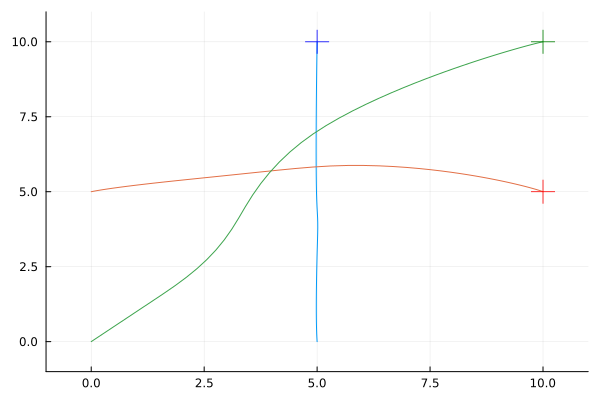

In [12]:
# Trajectories of that the agents followed

plot([X[:,1,:]], [X[:,2,:]], xlims = (-1, 11), ylims = (-1, 11), legend = false)
plot!([X[:,5,:]], [X[:,6,:]])
plot!([X[:,9,:]], [X[:,10,:]])
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :blue))
plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
plot!([xgoal[9]], [xgoal[10]], m = (:cross, 12, :green))

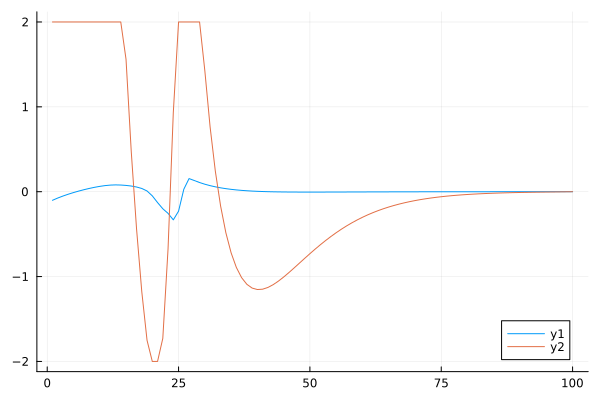

In [13]:
# Agent 1's input values 
# y1: F in x 
# y2: F in y

plot(U[:,1:2])

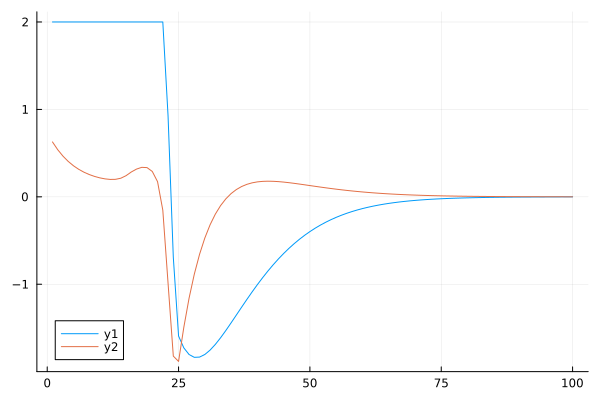

In [14]:
# Agent 2's input values 
# y1: F in x 
# y2: F in y

plot(U[:,3:4])

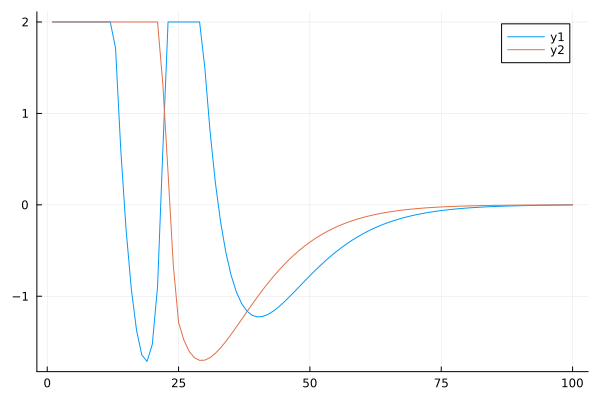

In [15]:
# Agent 3's input values 
# y1: F in x 
# y2: F in y

plot(U[:,5:6])